In [1]:
import matplotlib.pyplot as plt
import pywt
import numpy as np

from tabulated_wvt import TabulatedFunc, TabulatedWavelet
from wvt_basis_manager import WaveletBasisManager
from wvt_utils import calculate_quad_filter, calculate_diff_filter

array([1.88168917e-08, 6.75439116e-08, 2.14035507e-07, 8.99852513e-07,
       4.33303579e-06, 2.24354882e-05, 1.18388114e-04, 5.84301498e-04,
       2.52766032e-03, 9.28277509e-03, 2.86401632e-02, 7.45140001e-02,
       1.65840855e-01, 3.22379530e-01, 5.60134502e-01, 8.89519823e-01,
       1.31658674e+00, 1.84540096e+00, 2.48004701e+00, 3.22592490e+00,
       4.09051450e+00, 5.08376333e+00, 6.21811319e+00, 7.50807698e+00,
       8.96923153e+00, 1.06165066e+01, 1.24617223e+01, 1.45104524e+01,
       1.67584389e+01, 1.91879257e+01, 2.17643649e+01, 2.44339542e+01,
       2.71223410e+01, 2.97344780e+01, 3.21551035e+01, 3.42330111e+01,
       3.59395193e+01, 3.62936156e+01, 3.92086234e+01, 3.91065940e+01])

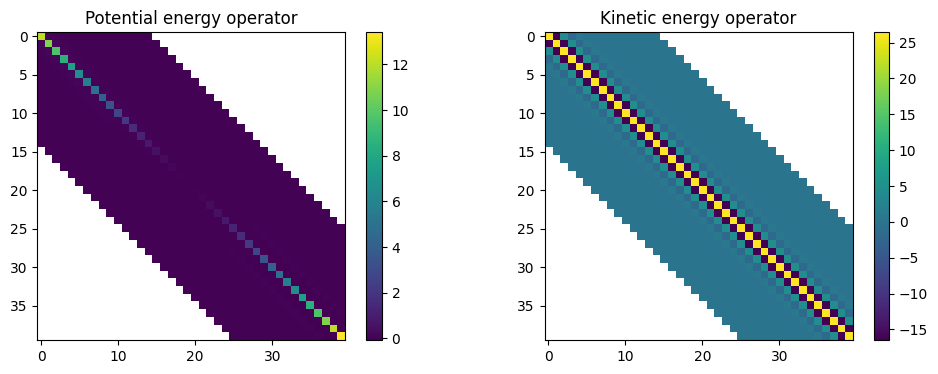

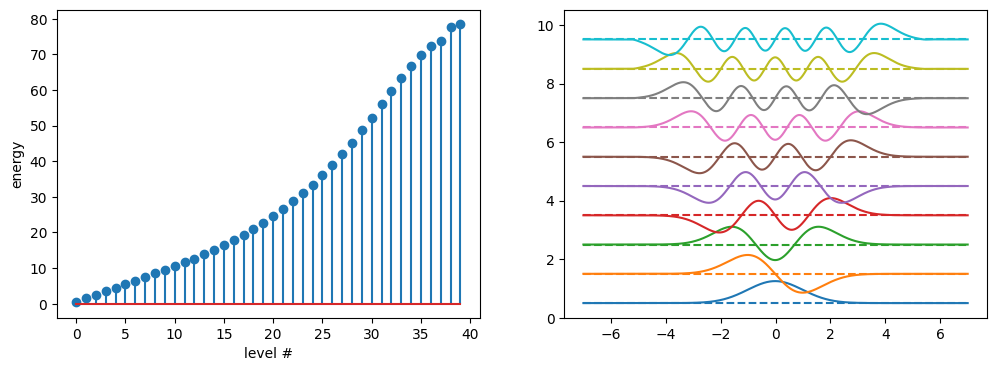

In [2]:
def experiment_quad(
    wvt_name="sym8",
    lims=(-7, 7),
    nsteps=40,
    do_plots=True,
    plot_levels=10,
    potential_grid_step=0.01,
):
    wvt = pywt.Wavelet(wvt_name)
    ww = calculate_quad_filter(wvt)
    aa = calculate_diff_filter(wvt)

    wvt_man = WaveletBasisManager(TabulatedWavelet(wvt), nsteps, lims, level=7, use_subscale=False)
    basis_size = len(wvt_man.basis_funcs)
    knots = np.linspace(
        *lims, np.round((lims[1] - lims[0]) / wvt_man.scale_factor).astype(int) + 1,
    )
    xxmin_vals = np.array([f.xx.min() for f in wvt_man.basis_funcs])
    assert np.allclose(xxmin_vals, knots[:len(wvt_man.basis_funcs)])

    potential_func = lambda xx: xx**2 / 2
    potential_knots = potential_func(knots)
    assert len(knots) == len(wvt_man.basis_funcs) + 2 * wvt_man.m - 1

    V_mat = np.zeros((basis_size, basis_size))
    T_mat = np.zeros((basis_size, basis_size))

    for i, j in wvt_man.iterate_overlapping_ids():
        assert j >= i
        ll = np.arange(j, i + 2 * wvt_man.m)
        V_mat[i, j] = V_mat[j, i] = (potential_knots[ll] * ww[ll - i] * ww[ll - j]).sum()
        T_mat[i, j] = T_mat[j, i] = -aa[2 * wvt_man.m - 2 + j - i] / 2 / wvt_man.scale_factor**2

    if do_plots:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(np.ma.masked_array(V_mat, V_mat == 0))
        plt.colorbar()
        plt.title("Potential energy operator")
        plt.subplot(1, 2, 2)
        plt.imshow(np.ma.masked_array(T_mat, T_mat == 0))
        plt.colorbar()
        plt.title("Kinetic energy operator")

    H_mat = V_mat + T_mat
    energies, states = np.linalg.eigh(H_mat)
    eigh_error = np.abs(H_mat @ states - states * energies[None, :]).max()
    if eigh_error > 1e-8:
        print("Warning: eigh error =", eigh_error)

    if do_plots:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.stem(energies)
        plt.xlabel("level #")
        plt.ylabel("energy")

        plt.subplot(1, 2, 2)
        for n in range(plot_levels):
            result_func = wvt_man.reconstruct(states[:, n]) + energies[n]
            line, = result_func.plot();
            plt.plot([result_func.xx[0], result_func.xx[-1]], [energies[n], energies[n]], "--", color=line.get_color())
        plt.ylim(bottom=0);

    return energies - (np.arange(len(energies)) + 0.5)

experiment_quad()

In [3]:
def mae(errors):
    return np.abs(errors[:6]).mean()

ranges = np.arange(4, 15, 0.5)
num_steps = [6, 10, 15, 20, 30, 40, 60, 80, 120, 160, 240, 320]

quality_quad = np.ones((len(ranges), len(num_steps))) * 999.0
for i_r, r in enumerate(ranges):
    print(f"range = {r}", flush=True)
    for i_s, s in enumerate(num_steps):
        quality_quad[i_r, i_s] = mae(experiment_quad(lims=(-r, r), nsteps=s, do_plots=False))

range = 4.0
range = 4.5
range = 5.0
range = 5.5
range = 6.0
range = 6.5
range = 7.0
range = 7.5
range = 8.0
range = 8.5
range = 9.0
range = 9.5
range = 10.0
range = 10.5
range = 11.0
range = 11.5
range = 12.0
range = 12.5
range = 13.0
range = 13.5
range = 14.0
range = 14.5


Text(0.5, 1.0, 'Quality (without subsampling)')

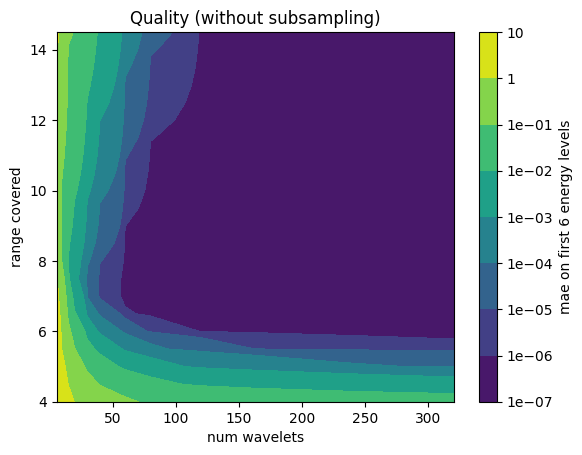

In [4]:
import matplotlib as mpl

plt.figure()
plt.contourf(num_steps, ranges, quality_quad, norm=mpl.colors.LogNorm(), levels=100)
plt.colorbar(format=mpl.ticker.LogFormatter(), label="mae on first 6 energy levels")
plt.xlabel("num wavelets")
plt.ylabel("range covered")
plt.title("Quality (without subsampling)")

In [5]:
def experiment_numeric(
    wvt_name="sym8",
    lims=(-7, 7),
    nsteps=40,
    level=5,
    use_subscale=False,
    do_plots=True,
    plot_levels=10,
    potential_grid_step=0.01,
):
    wvt = pywt.Wavelet(wvt_name)
    wvt_man = WaveletBasisManager(TabulatedWavelet(wvt), nsteps, lims, level, use_subscale)
    basis_size = len(wvt_man.basis_funcs)

    xx = np.linspace(*lims, np.ceil((lims[1] - lims[0]) / potential_grid_step).astype(int))
    potential = TabulatedFunc(xx, xx**2 / 2)

    V_mat = np.zeros((basis_size, basis_size))
    T_mat = np.zeros((basis_size, basis_size))
    for i, j in wvt_man.iterate_overlapping_ids():
        V_mat[i, j] = V_mat[j, i] = (wvt_man.basis_funcs[i] * wvt_man.basis_funcs[j] * potential).int().yy[-1]
        T_mat[i, j] = T_mat[j, i] = ((-0.5) * wvt_man.basis_funcs[i] * wvt_man.basis_funcs[j].der().der()).int().yy[-1]

    if do_plots:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(np.ma.masked_array(V_mat, V_mat == 0))
        plt.colorbar()
        plt.title("Potential energy operator")
        plt.subplot(1, 2, 2)
        plt.imshow(np.ma.masked_array(T_mat, T_mat == 0))
        plt.colorbar()
        plt.title("Kinetic energy operator")

    H_mat = V_mat + T_mat
    energies, states = np.linalg.eigh(H_mat)
    eigh_error = np.abs(H_mat @ states - states * energies[None, :]).max()
    if eigh_error > 1e-8:
        print("Warning: eigh error =", eigh_error)

    if do_plots:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.stem(energies)
        plt.xlabel("level #")
        plt.ylabel("energy")

        plt.subplot(1, 2, 2)
        for n in range(plot_levels):
            result_func = wvt_man.reconstruct(states[:, n]) + energies[n]
            line, = result_func.plot();
            plt.plot([result_func.xx[0], result_func.xx[-1]], [energies[n], energies[n]], "--", color=line.get_color())
        plt.ylim(bottom=0);

    return energies - (np.arange(len(energies)) + 0.5)

quality_numeric = np.ones((len(ranges), len(num_steps))) * 999.0
for i_r, r in enumerate(ranges):
    print(f"range = {r}", flush=True)
    for i_s, s in enumerate(num_steps):
        quality_numeric[i_r, i_s] = mae(experiment_numeric(lims=(-r, r), nsteps=s, do_plots=False))

range = 4.0
range = 4.5
range = 5.0
range = 5.5
range = 6.0
range = 6.5
range = 7.0
range = 7.5
range = 8.0
range = 8.5
range = 9.0
range = 9.5
range = 10.0
range = 10.5
range = 11.0
range = 11.5
range = 12.0
range = 12.5
range = 13.0
range = 13.5
range = 14.0
range = 14.5


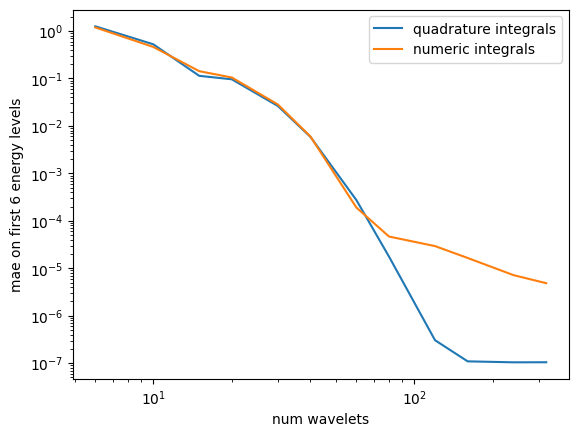

In [6]:
plt.plot(num_steps, quality_quad[-1], label="quadrature integrals");
plt.plot(num_steps, quality_numeric[-1], label="numeric integrals");
plt.ylabel("mae on first 6 energy levels")
plt.xlabel("num wavelets")
plt.yscale("log")
plt.xscale("log")
plt.legend();